# Imports

In [2]:
import pandas as pd
import numpy as np
import inspect
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib import pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

# # Imports for Pycox

# # For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn_pandas import DataFrameMapper 
from sklearn.metrics import mean_squared_error, r2_score


import torch # For building the networks 
import torchtuples as tt # Some useful functions

# import pycox as pc
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

In [2]:
from util import import_and_shape_data, run_pycox_on_group

interval_and_weather_merged = import_and_shape_data()

# interval_and_weather_merged.to_csv('./data/interval_and_weather_merged.csv')

# remove events with length larger than 5000
interval_and_weather_merged = interval_and_weather_merged[(interval_and_weather_merged['interval'] <= 5000)]

interval_and_weather_merged

(298, 21)
(46, 21)


,Unnamed: 0,endtime,starttime,interval,departing_insect,arriving_insect,sheet_title,timestamp_pd,timestamp_pd_rounded,same_species,...,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,status
0,0,0 days 11:41:43,0 days 11:44:13,150.0,Insecta,Insecta,07-28-2022 i10 Zinnia,2022-07-28 11:41:43,2022-07-28 12:00:00,1,...,100.0,0.0,NaN,270.0,7.2,NaN,1014.0,NaN,3.0,1
1,1,0 days 11:44:43,0 days 12:04:13,1170.0,Insecta,Syrphinae,07-28-2022 i10 Zinnia,2022-07-28 11:44:43,2022-07-28 12:00:00,0,...,100.0,0.0,NaN,270.0,7.2,NaN,1014.0,NaN,3.0,1
2,2,0 days 13:43:07,0 days 13:54:07,660.0,Halictus ligatus/poeyi,Syrphidae,07-28-2022 i4 Black-eyed Susan,2022-07-28 13:43:07,2022-07-28 14:00:00,0,...,79.0,0.0,NaN,271.0,8.3,NaN,1013.0,NaN,3.0,1
3,3,0 days 12:57:16,0 days 12:59:20,124.0,Augochlorini,Apis mellifera,08-04-2022 i8 Cup Plant,2022-08-04 12:57:16,2022-08-04 13:00:00,1,...,84.0,0.0,NaN,220.0,7.0,NaN,1019.0,NaN,1.0,1
4,4,0 days 13:00:22,0 days 13:00:53,31.0,Apis mellifera,Augochlorini,08-04-2022 i8 Cup Plant,2022-08-04 13:00:22,2022-08-04 13:00:00,1,...,84.0,0.0,NaN,220.0,7.0,NaN,1019.0,NaN,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,43,0 days 12:17:54,0 days 13:09:55,3121.0,Bombus impatiens,NaN,Great Blue Lobelia 08-25-2022 picture bag anal...,2022-08-25 12:17:54,2022-08-25 12:00:00,0,...,100.0,0.0,NaN,0.0,0.0,NaN,1019.0,NaN,1.0,1
42,41,0 days 12:38:26,0 days 12:39:56,90.0,apoidea,Poanes zabulon,Great Blue Lobelia 08-25-2022 unbagged,2022-08-25 12:38:26,2022-08-25 13:00:00,0,...,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0,1
43,42,0 days 12:40:56,0 days 13:54:27,4411.0,Poanes zabulon,Macroglossum stellatarum,Great Blue Lobelia 08-25-2022 unbagged,2022-08-25 12:40:56,2022-08-25 13:00:00,0,...,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0,1
44,44,0 days 13:10:55,0 days 13:20:55,600.0,NaN,NaN,Great Blue Lobelia 08-25-2022 picture bag anal...,2022-08-25 13:10:55,2022-08-25 13:00:00,1,...,100.0,0.0,NaN,0.0,0.0,NaN,1020.0,NaN,1.0,1


In [7]:
interval_and_weather_merged_filtered = interval_and_weather_merged.drop(['Unnamed: 0', 'snow', 'wpgt', 'tsun'], axis=1)
interval_and_weather_merged_filtered.dropna(axis=0, inplace=True)
interval_and_weather_merged_filtered.to_csv('./data/pollinator_arrival_interval_data.csv')

# First attempt at regression

INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
slope b1 is -0.0006776187411433997
intercept b0 is 0.5766594727875036


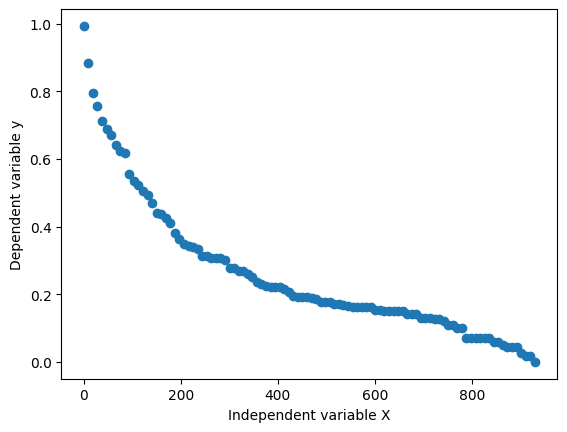

In [4]:
# Step 1: Select relevant columns
cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']
interval_and_weather_merged_under_1000 = interval_and_weather_merged[(interval_and_weather_merged['interval'] <= 1000)]
df_interval_and_weather_merged_under_1000 = interval_and_weather_merged_under_1000[cols_input]
fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(df_interval_and_weather_merged_under_1000, 100)
surv = base_model.predict_surv_df(x_test)

# Predict the slope and coefficients for time segment
# TODO: decide if these items should become a function 
surv['mean'] = surv.mean(axis=1)
surv['sem'] = surv.sem(axis='columns')

def run_linear_regression(surv):
  x = surv.index.values
  y = surv['mean'].values
  n = np.size(x)

  x_mean = np.mean(x)
  y_mean = np.mean(y)
  x_mean,y_mean

  Sxy = np.sum(x*y)- n*x_mean*y_mean
  Sxx = np.sum(x*x)-n*x_mean*x_mean

  b1 = Sxy/Sxx
  b0 = y_mean-b1*x_mean
  print('slope b1 is', b1)
  print('intercept b0 is', b0)

  plt.scatter(x,y)
  plt.xlabel('Independent variable X')
  plt.ylabel('Dependent variable y')

run_linear_regression(surv)

In [5]:
# Use Scikit to validate the results from manual regression
# x = x.reshape(-1,1)
# regression_model = LinearRegression()

# # Fit the data(train the model)
# regression_model.fit(x, y)

# # Predict
# y_predicted = regression_model.predict(x)

# # model evaluation
# mse=mean_squared_error(y,y_predicted)

# rmse = np.sqrt(mean_squared_error(y, y_predicted))
# r2 = r2_score(y, y_predicted)

# # printing values
# print('Slope:' ,regression_model.coef_)
# print('Intercept:', regression_model.intercept_)
# print('MSE:',mse)
# print('Root mean squared error: ', rmse)
# print('R2 score: ', r2)

In [6]:
# TODO make the lt(.5) a data point
def format_survival_data(surv, less_than_value):
    # Find index values where each column is less than 0.5
    less_than_half = surv.lt(less_than_value)

    # Get the first index where the condition is true for each column
    first_less_than_half = less_than_half.idxmax()

    # Print the index values
    # for column in first_less_than_half.index:
    #     print(f"Column {column}:")
    #     print(first_less_than_half[column])
    #     print()


    return np.array(first_less_than_half)

# surv.drop(['sem', 'mean'], inplace=True, axis=1)
# first_less_than_half_array = format_survival_data(surv, .5)

# Multiple Regression
def run_multiple_regression(df_test, dependent_variable):
  
  x = df_test.drop(['status', 'interval'], axis=1)

  # Create the dependent variable
  y = dependent_variable

  # Create the regression model
  model = LinearRegression()

  # Fit the model to the data
  model.fit(x, y)

  # Get the coefficients
  coefficients = pd.DataFrame(zip(x.columns, model.coef_))

  # Get the intercept
  intercept = model.intercept_

  # Print the results
  # print('Coefficients:', coefficients)
  # print('Intercept:', intercept)

  return coefficients, intercept

# Run the regression with statsmodels
# model2 = ols(formula='interval ~ same_insect + temp + wspd + dwpt + coco', data=data)
# results = model2.fit()

# # Print the results from statsmodels
# print(results.summary())
# first_less_than_half_array = format_survival_data(surv, .1)
# run_multiple_regression(df_test, first_less_than_half_array)

In [7]:
# Moving the cut-off of first 1000 seconds to after training pycox model
cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']
interval_and_weather_merged = interval_and_weather_merged[cols_input]
fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(interval_and_weather_merged, 1000)

df_test_under_1000 = df_test[(df_test['interval'] <= 1000)]
x_test_under_1000 = x_mapper.transform(df_test_under_1000).astype('float32')
surv = base_model.predict_surv_df(x_test_under_1000)

first_less_than_half_array = format_survival_data(surv, .1)
run_multiple_regression(df_test_under_1000, first_less_than_half_array)


INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah


(              0           1
 0          temp   29.729193
 1          dwpt   -9.350819
 2          wspd  -24.990217
 3          coco  -51.234072
 4  same_species -144.177643,
 373.27214899251726)

# New functions based on updated guidance for regression

### TODO:
- Go back and figure out how to get smaller increments of time from base_model.predict_surv_df(x_test) call. Look at this https://github.com/havakv/pycox/issues/58
- Validate the output of get_slope_of_population_curve function

- Potentailly need to get the slope of the curve for each individual survival curve

In [8]:
def get_slope_of_survival_curve(surv, start_time, end_time):

  sliced_surv = surv.loc[(surv.index >= start_time) & (surv.index <= end_time)]
  
  x = sliced_surv.index.values
  y = sliced_surv.values
  # n = np.size(x)
  # print('inside get_slope', x, y, n)

  # Use Scikit to get slope
  x = x.reshape(-1,1)
  regression_model = LinearRegression()

  # Fit the data(train the model)
  regression_model.fit(x, y)

  return regression_model.coef_[0]

# TODO: Rewrite this function to not alter surv but instead to create a copy
def get_slope_of_population_curve(surv, start_time, end_time):
  surv['mean'] = surv.mean(axis=1)
  surv['sem'] = surv.sem(axis='columns')

  sliced_surv = surv.loc[(surv.index >= start_time) & (surv.index <= end_time)]
  # print('sliced_surv', sliced_surv)


  
  x = sliced_surv.index.values
  y = sliced_surv['mean'].values
  print(y)
  n = np.size(x)

  # Use Scikit to get slope
  x = x.reshape(-1,1)
  regression_model = LinearRegression()

  # Fit the data(train the model)
  regression_model.fit(x, y)

  # Predict
  y_predicted = regression_model.predict(x)

  # model evaluation
  mse=mean_squared_error(y,y_predicted)

  rmse = np.sqrt(mean_squared_error(y, y_predicted))
  r2 = r2_score(y, y_predicted)

  # printing values
  # print('Slope:' ,regression_model.coef_)
  # print('Intercept:', regression_model.intercept_)
  # print('MSE:',mse)
  # print('Root mean squared error: ', rmse)
  # print('R2 score: ', r2)
  return regression_model.coef_[0]


get_slope_of_population_curve(surv, 50, 150)

[0.7443368  0.7374688  0.72954583 0.71637607 0.7052897  0.7002326
 0.69586295 0.6902716  0.6856479  0.6583692  0.65412414 0.6497664
 0.6478103  0.6356038  0.6202674  0.6128803  0.60883486 0.60474217
 0.59921825 0.58596927 0.57659626 0.57202494]


-0.0018191460461234972

In [9]:
start=50
end=150
# Get predicted survivals for all relevant data 
df_test_active = df_test[(df_test['interval'] >= start)]
x_test_active = x_mapper.transform(df_test_active).astype('float32')
surv = base_model.predict_surv_df(x_test_active)

In [10]:
# Create the dependent variable with the population slope curve
# y = np.full(df_test_active.shape[0], slope_of_population_curve)

# Create the dependent variable with the population slope curve
y = df_test_active['surv_slope']
df_test_active.drop(['surv_slope'], axis=1)

# run a regression with the data and from the test and the slope
x = df_test_active.drop(['status', 'interval'], axis=1)

# Create the regression model
model = LinearRegression()

# Fit the model to the data
model.fit(x, y)

# Get the coefficients
coefficients = pd.DataFrame(zip(x.columns, model.coef_))

# Get the intercept
intercept = model.intercept_

# Print the results
print('Coefficients:', coefficients)
print('Intercept:', intercept)

KeyError: 'surv_slope'

In [11]:
# For loop for running regression on time-segments
time_segments = []
coefficients_object = {}

interval = 300
for i in range(0, 3201, interval):
  start = i
  end = i+interval
  
  # Get predicted survivals for all relevant data 
  # df_test_active = df_test[(df_test['interval'] >= start)]
  df_full_active = interval_and_weather_merged[(interval_and_weather_merged['interval'] >= start)]
  
  x_test_active = x_mapper.transform(df_full_active).astype('float32')
  surv = base_model.predict_surv_df(x_test_active)
  # print(surv.shape)
  # Apply the get_slope_of_survival_curve function to every column in 'surv'
  slope_values = np.array(surv.apply(lambda col: get_slope_of_survival_curve(col, start, end)))
  # print('slope_values', slope_values[0])


  print(f'running regression for time-segment {start}-{end} seconds')
  print('size of active test data', df_full_active.shape[0])
  # run a regression with the data and from the test and the slope
  coefficients, intercept  = run_multiple_regression(df_full_active, slope_values)
  coefficients['abs_value'] = coefficients[1].abs()
  sorted_coefficients = coefficients.sort_values(by='abs_value', ascending=False)


  # Print the results
  # print('Coefficients:', sorted_coefficients)
  print('Intercept:', intercept)

  # Append time segment and coefficients to respective lists/dictionaries
  time_segments.append(f'{start}-{end} seconds')
  for index, row in sorted_coefficients.iterrows():
      coeff_name = row[0]
      coeff_value = row['abs_value']
      if coeff_name not in coefficients_object:
          coefficients_object[coeff_name] = []
      coefficients_object[coeff_name].append(coeff_value)
  
  # print(time_segments, coefficients_object)
  # break

# Manually calculate the slope of the population survival curve for the time-segment
# slope_of_population_curve = get_slope_of_population_curve(surv_general, start, end)

# run a regression with the data and from the test and the slope
# slope_of_population_curve

running regression for time-segment 0-300 seconds
size of active test data 291
Intercept: -0.0017786249885275325
running regression for time-segment 300-600 seconds
size of active test data 134
Intercept: 7.05990263727451e-06
running regression for time-segment 600-900 seconds
size of active test data 95
Intercept: 0.0002930287502710458
running regression for time-segment 900-1200 seconds
size of active test data 65
Intercept: 4.763319724035756e-05
running regression for time-segment 1200-1500 seconds
size of active test data 52
Intercept: -2.9373002316516084e-06
running regression for time-segment 1500-1800 seconds
size of active test data 41
Intercept: 7.119316458411928e-05
running regression for time-segment 1800-2100 seconds
size of active test data 31
Intercept: -3.116608276425363e-05
running regression for time-segment 2100-2400 seconds
size of active test data 24
Intercept: -9.989296009203522e-05
running regression for time-segment 2400-2700 seconds
size of active test data 18
I

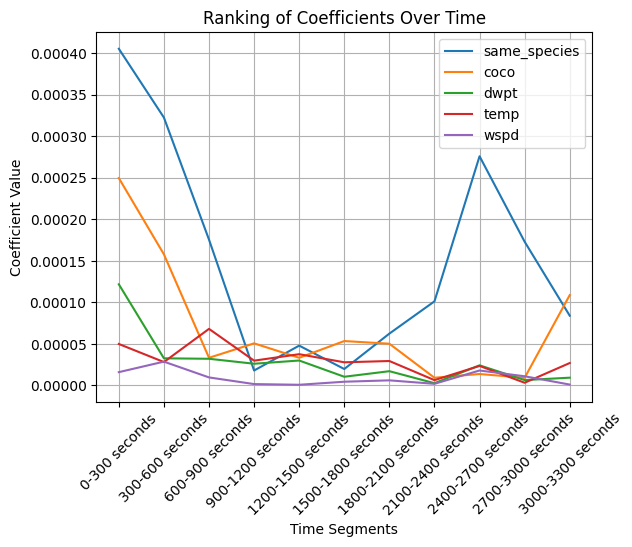

In [ ]:
# Plotting
def plot_coeff_weights(coefficients_object, time_segments):
    for coeff_name, coeff_values in coefficients_object.items():
        plt.plot(time_segments, coeff_values, label=coeff_name)

    plt.xlabel('Time Segments')
    plt.ylabel('Coefficient Value')
    plt.title('Ranking of Coefficients Over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.show()
plot_coeff_weights(coefficients_object, time_segments)

### Run trad cox on the same time segments

In [ ]:
# TODO: Turn each of the methods into a function so I can run both methods with the same for-loop
# For loop for running regression on time-segments
time_segments_cox_trad = []
coefficients_object_cox_trad = {}

interval = 300
for i in range(0, 3201, interval):
  start = i
  end = i+interval

  interval_and_weather_merged_active = interval_and_weather_merged[(interval_and_weather_merged['interval'] >= start)]
  # interval_and_weather_merged_active = interval_and_weather_merged[(interval_and_weather_merged['interval'] >= start) & (interval_and_weather_merged['interval'] <= end)]
  # print(interval_and_weather_merged_active)
  cph = CoxPHFitter()
  cph.fit(interval_and_weather_merged_active, duration_col='interval', event_col='status', formula="same_species + temp + wspd + dwpt + coco")

  # Append time segment and coefficients to respective lists/dictionaries
  time_segments_cox_trad.append(f'{start}-{end} seconds')
  print(f'running regression for time-segment {start}-{end} seconds')
  print('size of active test data', interval_and_weather_merged_active.shape[0])
  results = cph.summary
  results['abs_value'] = results['coef'].abs()
#   print(results.head())  

  for index, row in results.iterrows():
      coeff_name = index
      coeff_value = row['abs_value']
      if coeff_name not in coefficients_object_cox_trad:
          coefficients_object_cox_trad[coeff_name] = []
      coefficients_object_cox_trad[coeff_name].append(coeff_value)

#   print(time_segments_cox_trad, coefficients_object_cox_trad)
  # break

running regression for time-segment 0-300 seconds
size of active test data 291
running regression for time-segment 300-600 seconds
size of active test data 134
running regression for time-segment 600-900 seconds
size of active test data 95
running regression for time-segment 900-1200 seconds
size of active test data 65
running regression for time-segment 1200-1500 seconds
size of active test data 52
running regression for time-segment 1500-1800 seconds
size of active test data 41
running regression for time-segment 1800-2100 seconds
size of active test data 31
running regression for time-segment 2100-2400 seconds
size of active test data 24
running regression for time-segment 2400-2700 seconds
size of active test data 18
running regression for time-segment 2700-3000 seconds
size of active test data 13
running regression for time-segment 3000-3300 seconds
size of active test data 9


In [ ]:
results.columns

for index, row in results.iterrows():
      coeff_name = index
      print('coeff_name', coeff_name)
      coeff_value = row['abs_value']
      if coeff_name not in coefficients_object:
          coefficients_object[coeff_name] = []
      coefficients_object[coeff_name].append(coeff_value)

coeff_name coco
coeff_name dwpt
coeff_name same_species
coeff_name temp
coeff_name wspd


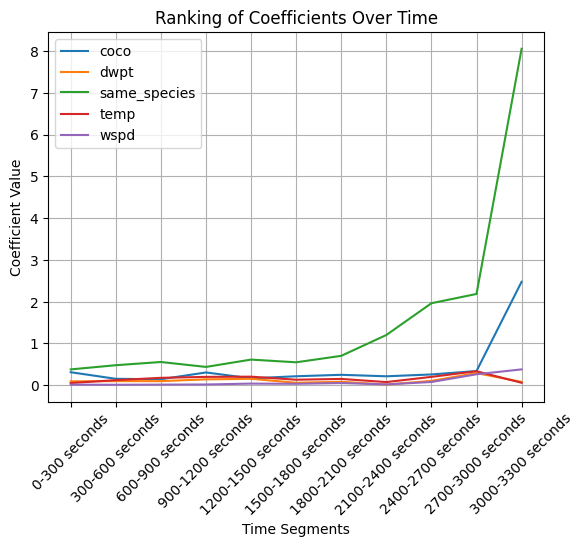

In [ ]:
plot_coeff_weights(coefficients_object_cox_trad, time_segments_cox_trad)

# Generative Models
### TODO: 
- Remember that when we were building poisson before we were not just using the interval value but instead grouping arrivals by how many we saw in a certain number of visits.  
    - Note this data will be hard to convert back into the same type of grouped segments because we have lost the order in which the arrivals occured. We can however group by the length of the interval
- Get a measure of accuracy to the original data 

- Need to normalize my two overlayed histograms to make them instead probabilities 

### Exploratory work

In [ ]:
s = np.random.poisson(.5, 10000)
s

array([1, 0, 1, ..., 2, 0, 1])

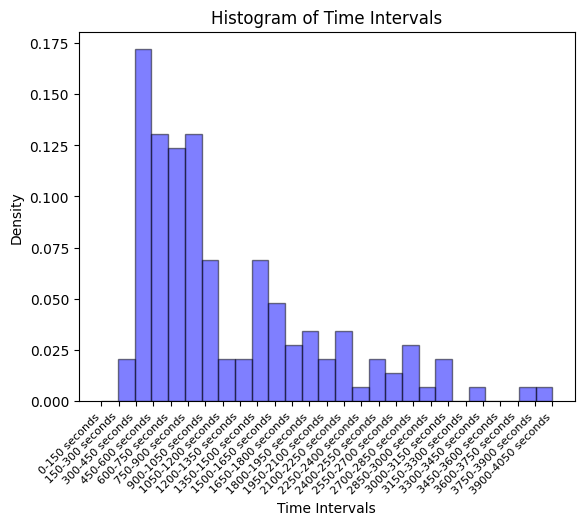

estimated lambda 5.592592592592593
(0-150 seconds, 0.003725357000834866)
(150-300 seconds, 0.020834403967632028)
(300-450 seconds, 0.05825916665023029)
(450-600 seconds, 0.10860659461956511)
(600-750 seconds, 0.15184810914402155)
(750-900 seconds, 0.16984492207960947)
(900-1050 seconds, 0.15831224218531478)
(1050-1200 seconds, 0.126482267566045)
(1200-1350 seconds, 0.08842047408552224)
(1350-1500 seconds, 0.05494440982269089)
(1500-1650 seconds, 0.030728169937875263)
(1650-1800 seconds, 0.01562273959804428)
(1800-1950 seconds, 0.007280968146002141)
(1950-2100 seconds, 0.0031322683477103264)
(2100-2250 seconds, 0.0012512500542440639)
(2250-2400 seconds, 0.0004665154523230956)
(2400-2550 seconds, 0.00016306442893700818)
(2550-2700 seconds, 5.364428925814439e-05)
(2700-2850 seconds, 1.6667258596666323e-05)
(2850-3000 seconds, 4.905957208765309e-06)
(3000-3150 seconds, 1.3718509972658618e-06)
(3150-3300 seconds, 3.6534303454522866e-07)
(3300-3450 seconds, 9.287339767058782e-08)
(3450-3600 

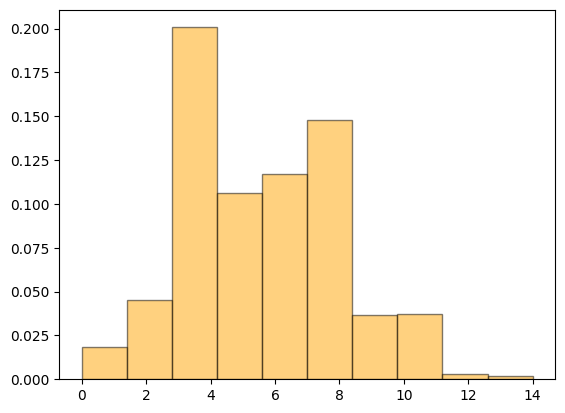

In [16]:
def group_by_length_of_interval(interval, df):
  counts = []
  bins = []
  grouped_arrivals = []
  for i in range(0, 4001, interval):
    start = i
    end = i+interval
    df_active = df[(df['interval'] >= start) & (df['interval'] <= end)]
    grouped_arrivals.append((f'{start}-{end} seconds', df_active.shape[0]))
    counts.append(df_active.shape[0])
    bins.append(f'{start}-{end} seconds')

  return grouped_arrivals, counts, bins

  
interval=150
# With the full dataset
# grouped_arrivals, counts, bins = group_by_length_of_interval(interval, interval_and_weather_merged)

# With the filtered section by windspeed importance 
df_full_active = interval_and_weather_merged[(interval_and_weather_merged['interval'] >= 300)]
grouped_arrivals, _, _ = group_by_length_of_interval(interval, df_full_active)

# plt.hist(counts, bins, density=True, edgecolor='black', alpha=0.5)
# Extract x-axis values and counts from the data
x_values = [item[0] for item in grouped_arrivals]
counts = [item[1] for item in grouped_arrivals]

# Plotting the histogram
# plt.bar(x_values, counts)
plt.hist(x_values, bins=len(x_values), weights=counts, density=True, edgecolor='black', alpha=0.5, color='blue', label='Original Data')

plt.xlabel('Time Intervals')
plt.ylabel('Density')
plt.title('Histogram of Time Intervals')
plt.xticks(rotation=45)

# Adjusting spacing and alignment of x-ticks
plt.xticks(range(len(x_values)), x_values, ha='right', fontsize=8)
plt.show()

 # Find the mean of the data
lambda_fit = np.mean(counts)
print('estimated lambda', lambda_fit)

x = list(range(int(np.min(counts)), int(np.max(counts))+1))
# plt.scatter(x, stats.poisson.pmf(x, lambda_fit),color="red")

# Comparison between 
zip_obj = zip(x_values, stats.poisson.pmf(x, lambda_fit))

# Print the zip object nicely
for item in zip_obj:
    print(f'({item[0]}, {item[1]})')

# Generate 1000 values from the Poisson distribution
generated_values = stats.poisson.rvs(mu=lambda_fit, size=1000)
plt.hist(generated_values, bins=10, density=True, edgecolor='black', alpha=0.5,  color='orange', label='Generated Values')


plt.show()

**Note:** Is this histogram really a poisson distribution? Because we are graphing the number of arrivals that fall within a certain 
Not the observed number of k events that happened within an observed interval. 

Optimization terminated successfully.
         Current function value: 460.031580
         Iterations 1
                          Poisson Regression Results                          
Dep. Variable:               interval   No. Observations:                  291
Model:                        Poisson   Df Residuals:                      290
Method:                           MLE   Df Model:                            0
Date:                Wed, 26 Jul 2023   Pseudo R-squ.:                   0.000
Time:                        22:29:54   Log-Likelihood:            -1.3387e+05
converged:                       True   LL-Null:                   -1.3387e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4376      0.002   2745.209      0.000       6.433       6.442
mu 624.9003436426115


/var/folders/vt/546593w53sx4zw12xsp5qhx00000gp/T/ipykernel_16929/2818029691.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(s, kde = False, norm_hist = True, label= 'Real Values')


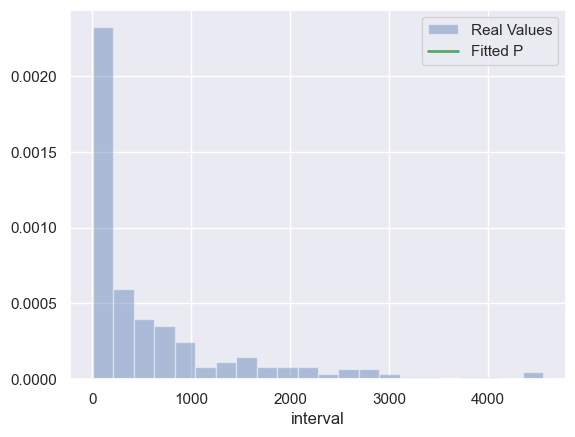

In [ ]:
def fit_poisson(s_data):
  # Attempt a similiair graph with Poisson
  # s = np.random.poisson(.5, 10000)
  s = s_data
  X = np.ones_like(s)

  # This fits the model using maximum likelyhood
  res = sm.Poisson(s,X).fit()
  print(res.summary())
  # In this readout The term const is, in fact, the estimate of log(μ), while alpha is the over-dispersion parameter

  # recover mean and variance params
  mu = np.exp(res.params[0])
  # p = 1/(1 + mu * res.params[1])
  # n = mu*p / (1-p)
  print('mu', mu)

  # # Graph it
  x_plot = np.linspace(0, 4, 5)
  sns.set_theme()
  ax = sns.distplot(s, kde = False, norm_hist = True, label= 'Real Values')
  ax.plot(x_plot, stats.poisson.pmf(x_plot, mu), 'g-', lw=2, label="Fitted P")
  leg = ax.legend()

fit_poisson(interval_and_weather_merged['interval'])

Optimization terminated successfully.
         Current function value: 451.198650
         Iterations 1
                          Poisson Regression Results                          
Dep. Variable:               interval   No. Observations:                  135
Model:                        Poisson   Df Residuals:                      134
Method:                           MLE   Df Model:                            0
Date:                Wed, 14 Jun 2023   Pseudo R-squ.:                   0.000
Time:                        15:20:55   Log-Likelihood:                -60912.
converged:                       True   LL-Null:                       -60912.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1888      0.002   3039.755      0.000       7.184       7.193
mu 1324.4518518518519


/var/folders/vt/546593w53sx4zw12xsp5qhx00000gp/T/ipykernel_25473/2818029691.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(s, kde = False, norm_hist = True, label= 'Real Values')


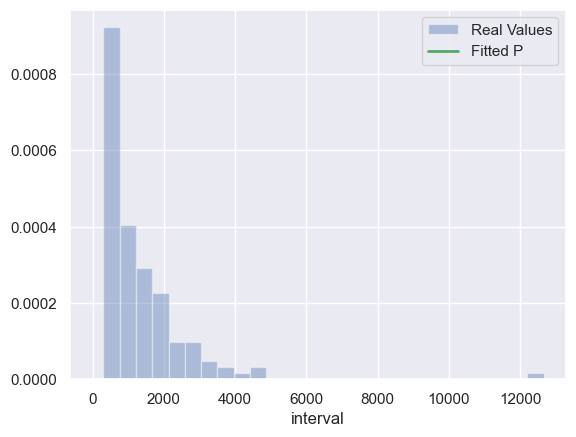

In [ ]:
# Clipping for a section where windspeed is more predictive

# Looking at graph we see that windspeed is most predictive at 300-450 so we left censor at 300
df_full_active = interval_and_weather_merged[(interval_and_weather_merged['interval'] >= 300)]
fit_poisson(df_full_active['interval'])


estimated lambda 3.962962962962963
(0-150 seconds, 0.019006714586387495)
(150-300 seconds, 0.07532290595346156)
(300-450 seconds, 0.1492509432781553)
(450-600 seconds, 0.19715865346620506)
(600-750 seconds, 0.19533311037855508)
(750-900 seconds, 0.15481957637411414)
(900-1050 seconds, 0.10225737451870484)
(1050-1200 seconds, 0.05789174112963715)
(1200-1350 seconds, 0.028677853244773965)
(1350-1500 seconds, 0.012627696696258515)
(1500-1650 seconds, 0.005004309431480222)
(1650-1800 seconds, 0.0018028993574693032)
(1800-1950 seconds, 0.0005954019483000481)
(1950-2100 seconds, 0.00018150429762992955)
(2100-2250 seconds, 5.137820065185819e-05)
(2250-2400 seconds, 1.3573993752466237e-05)
(2400-2550 seconds, 3.362077156282147e-06)
(2550-2700 seconds, 7.837521911158828e-07)
(2700-2850 seconds, 1.725544947518513e-07)
(2850-3000 seconds, 3.599089851549331e-08)


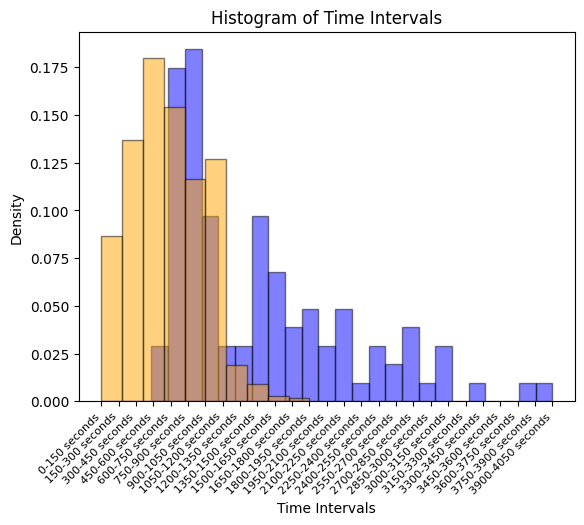

In [ ]:
# TODO: Figure out the difference between this code and the top. My guess is just that rather than creating two histograms. This code overlays the two histograms  
interval=150
# With the full dataset
# grouped_arrivals, counts, bins = group_by_length_of_interval(interval, interval_and_weather_merged)

# With the filtered section by windspeed importance 
df_full_active = interval_and_weather_merged[(interval_and_weather_merged['interval'] >= 600)]
grouped_arrivals, _, _ = group_by_length_of_interval(interval, df_full_active)

# plt.hist(counts, bins, density=True, edgecolor='black', alpha=0.5)
# Extract x-axis values and counts from the data
x_values = [item[0] for item in grouped_arrivals]
counts = [item[1] for item in grouped_arrivals]

# Plotting the histogram
# plt.bar(x_values, counts)
plt.hist(x_values, bins=len(x_values), weights=counts, density=True, edgecolor='black', alpha=0.5, color='blue', label='Original Data')

plt.xlabel('Time Intervals')
plt.ylabel('Density')
plt.title('Histogram of Time Intervals')
plt.xticks(rotation=45)

# Adjusting spacing and alignment of x-ticks
plt.xticks(range(len(x_values)), x_values, ha='right', fontsize=8)
# plt.show()

 # Find the mean of the data
lambda_fit = np.mean(counts)
print('estimated lambda', lambda_fit)

x = list(range(int(np.min(counts)), int(np.max(counts))+1))
# plt.scatter(x, stats.poisson.pmf(x, lambda_fit),color="red")

# Comparison between 
zip_obj = zip(x_values, stats.poisson.pmf(x, lambda_fit))

# Print the zip object nicely
for item in zip_obj:
    print(f'({item[0]}, {item[1]})')

# Generate 1000 values from the Poisson distribution
generated_values = stats.poisson.rvs(mu=lambda_fit, size=1000)
plt.hist(generated_values, bins=10, density=True, edgecolor='black', alpha=0.5,  color='orange', label='Generated Values')


plt.show()

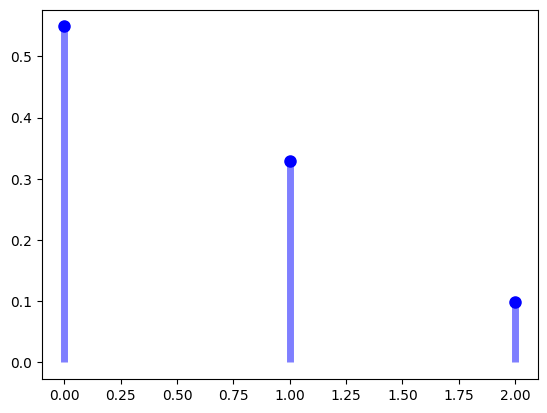

In [ ]:
# Expirementing with scipy stats generative functions
fig, ax = plt.subplots(1, 1)
mu = 0.6
mean, var, skew, kurt = stats.poisson.stats(mu, moments='mvsk')
x = np.arange(stats.poisson.ppf(0.01, mu),
              stats.poisson.ppf(0.99, mu))
ax.plot(x, stats.poisson.pmf(x, mu), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, stats.poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

### Generative Models on "Treatment Groups"

In [12]:
def run_bin_temp_analysis(df, binned_column, number_of_bins):
    # Find the range of the `temp` column
    temp_min = df[binned_column].min()
    temp_max = df[binned_column].max()

    print(f"Photo data {binned_column} range")
    print(temp_min)
    print(temp_max)

    # Calculate the range of each group based on the total range of `temp`
    group_range = (temp_max - temp_min) / 3
    print(group_range)
    # Create a new column in the DataFrame to hold the temperature group for each row
    df['binned_group'] = pd.cut(df[binned_column], bins=[temp_min, temp_min+group_range, temp_min+2*group_range, temp_max], labels=['Low', 'Medium', 'High'])

    group_object = {}
    # Print out the DataFrame grouped by temperature group
    for name, group in interval_and_weather_merged.groupby('binned_group'):
        print(f"Group: {name}\n")
        print(f"Number of rows in group: {len(group)}\n")
        group_object.update({name: group})
        group_temp_range = f"{name}: {group['temp'].min()} - {group['temp'].max()}"
        print('group_temp_range', group_temp_range)

        status = np.ones(len(group))

        cph = CoxPHFitter()
        cph.fit(group, duration_col='interval', event_col='status', formula="same_species + temp + wspd + dwpt + coco")

        cph.print_summary()

        # mod = smf.phreg("interval ~ same_species + temp + wspd + dwpt + coco",
        #                 group, status=status, ties="efron")
        # rslt = mod.fit()
        # print(rslt.summary())
    return group_object
    
# df_minus_short_interval_same_species

temp_groups = run_bin_temp_analysis(interval_and_weather_merged, 'temp', 3)

# temp_groups

Photo data temp range
12.0
31.0
6.333333333333333
Group: Low

Number of rows in group: 80

group_temp_range Low: 14.0 - 18.0


<lifelines.CoxPHFitter: fitted with 80 total observations, 0 right-censored observations>
             duration col = 'interval'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 80
number of events observed = 80
   partial log-likelihood = -260.26
         time fit was run = 2023-08-09 20:26:24 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
coco           0.46       1.58       0.13             0.21             0.71                 1.24                 2.03
dwpt          -0.19       0.83       0.05            -0.30            -0.08                 0.74                 0.92
same_species  -0.08       0.92       0.37            -0.80             0.64                 0.45                 1.89
temp          -0.05       0.95       0.11            -0.26             0.16                 0.77                 1.18
wspd           0.02       1.02       0.02            -0.03             0.06                 0.97                 1.06

               cmp to     z      p   -log2(p)
covariate                                    
coco             0.00  3.65 <0.005      11.89
dwpt             0.00 -3.48 <0.005      10.95
same_species     0.00 -0.22   0.83       0.27
temp             0.00 -0.46   0.65       0.63
wspd             0.00  0.65   0.51       0.96
---
Concordance = 0.69
Partial AIC = 530.52
log-likelihood ratio test = 26.83 on 5 df
-log2(p) of ll-ratio test = 13.99

Group: Medium

Number of rows in group: 156

group_temp_range Medium: 20.0 - 24.0


<lifelines.CoxPHFitter: fitted with 156 total observations, 0 right-censored observations>
             duration col = 'interval'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 156
number of events observed = 156
   partial log-likelihood = -618.74
         time fit was run = 2023-08-09 20:26:24 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
coco           0.31       1.37       0.09             0.14             0.49                 1.15                 1.63
dwpt          -0.10       0.91       0.03            -0.15            -0.05                 0.86                 0.95
same_species   0.40       1.49       0.17             0.06             0.74                 1.06                 2.09
temp           0.04       1.04       0.08            -0.11             0.20                 0.90                 1.22
wspd           0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06

               cmp to     z      p   -log2(p)
covariate                                    
coco             0.00  3.46 <0.005      10.88
dwpt             0.00 -3.88 <0.005      13.22
same_species     0.00  2.31   0.02       5.57
temp             0.00  0.55   0.58       0.78
wspd             0.00  0.49   0.62       0.69
---
Concordance = 0.51
Partial AIC = 1247.48
log-likelihood ratio test = 32.97 on 5 df
-log2(p) of ll-ratio test = 18.00

Group: High

Number of rows in group: 49

group_temp_range High: 25.0 - 31.0


<lifelines.CoxPHFitter: fitted with 49 total observations, 0 right-censored observations>
             duration col = 'interval'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 49
number of events observed = 49
   partial log-likelihood = -140.73
         time fit was run = 2023-08-09 20:26:24 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
coco          -0.12       0.89       0.25            -0.62             0.38                 0.54                 1.46
dwpt          -0.26       0.77       0.14            -0.53             0.01                 0.59                 1.01
same_species   0.39       1.48       0.31            -0.21             0.99                 0.81                 2.70
temp           0.39       1.47       0.21            -0.02             0.79                 0.98                 2.21
wspd           0.02       1.02       0.05            -0.08             0.12                 0.92                 1.13

               cmp to     z    p   -log2(p)
covariate                                  
coco             0.00 -0.48 0.63       0.66
dwpt             0.00 -1.90 0.06       4.12
same_species     0.00  1.28 0.20       2.31
temp             0.00  1.87 0.06       4.03
wspd             0.00  0.44 0.66       0.60
---
Concordance = 0.48
Partial AIC = 291.45
log-likelihood ratio test = 7.68 on 5 df
-log2(p) of ll-ratio test = 2.52

In [13]:
def graph_mean_and_sem(surv, group_name):
  surv['mean'] = surv.mean(axis=1)
  surv['sem'] = surv.sem(axis='columns')
  
  # Calculate the upper and lower error bounds
  surv['upper_bound'] = surv['mean'] + surv['sem']
  surv['lower_bound'] = surv['mean'] - surv['sem']

  # Create the figure and axis objects
  fig, ax = plt.subplots()



  # Plot the error bars
  # ax.errorbar(surv.index, surv['mean'], yerr=surv['sem'], color='red', label='Error Bars')

  # Fill between the upper and lower error bounds
  ax.fill_between(surv.index, surv['lower_bound'], surv['upper_bound'], color='red', alpha=0.3, label='Error Bars')


  # Plot the mean line
  ax.plot(surv.index, surv['mean'], color='blue', label='Mean')

  # Set the axis labels and title
  ax.set_xlabel('Time (In Seconds)')
  ax.set_ylabel('S(t | x)')
  ax.set_title(f'{group_name} Group Estimated Population with Error Bars')

  # Add a legend
  ax.legend()

  # Show the plot
  plt.show()

# graph_mean_and_sem(surv, 'x_test')

#### Code taken from earlier up in the generative section

estimated lambda 2.962962962962963


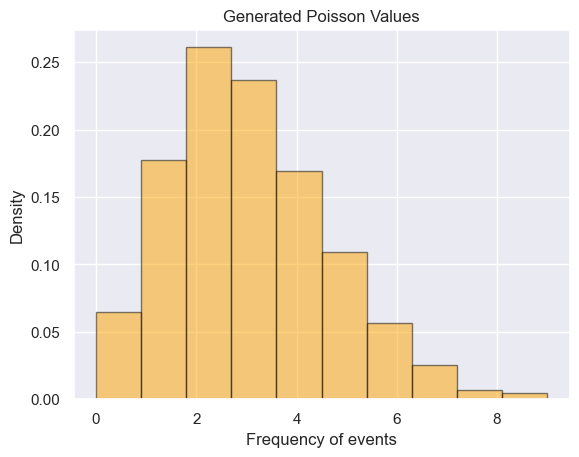

In [ ]:
# Build generative models for each treatment group
def graph_and_fit_poisson(grouped_arrivals):
    # Extract x-axis values and counts from the data
    x_values = [item[0] for item in grouped_arrivals]
    counts = [item[1] for item in grouped_arrivals]

    # Plotting the histogram
    # plt.bar(x_values, counts)
    # plt.hist(x_values, bins=len(x_values), weights=counts, density=True, edgecolor='black', alpha=0.5, color='blue', label='Original Data')


    # plt.xticks(rotation=45)

    # Adjusting spacing and alignment of x-ticks
    # plt.xticks(range(len(x_values)), x_values, ha='right', fontsize=8)
    # plt.show()

    # Find the mean of the data
    lambda_fit = np.mean(counts)
    print('estimated lambda', lambda_fit)

    # x = list(range(int(np.min(counts)), int(np.max(counts))+1))
    # plt.scatter(x, stats.poisson.pmf(x, lambda_fit),color="red")

    # Comparison between 
    # zip_obj = zip(x_values, stats.poisson.pmf(x, lambda_fit))

    # Print the zip object nicely
    # for item in zip_obj:
    #     print(f'({item[0]}, {item[1]})')

    # Generate 1000 values from the Poisson distribution
    generated_values = stats.poisson.rvs(mu=lambda_fit, size=1000)
    plt.hist(generated_values, bins=10, density=True, edgecolor='black', alpha=0.5,  color='orange', label='Generated Values')


    plt.xlabel('Frequency of events')
    plt.ylabel('Density')
    plt.title('Generated Poisson Values')
    plt.show()

interval=150
df = temp_groups['Low']
grouped_arrivals, _, _ = group_by_length_of_interval(interval, df)
graph_and_fit_poisson(grouped_arrivals)

Low
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
estimated lambda 2.962962962962963


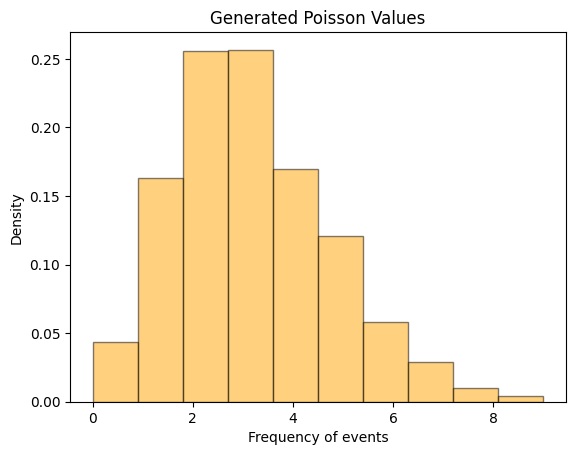

In [ ]:
interval=150
for group in temp_groups:
  print(group)
  df = temp_groups[group]
  cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']
  df_train = df[cols_input]
  fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(df_train, 1000)
  surv = base_model.predict_surv_df(x_test)
  # graph_mean_and_sem(surv, f'{group} Temperature')
  
  # plot_training_val_loss(fit_model, base_model, x_test)
  grouped_arrivals, _, _ = group_by_length_of_interval(interval, df)
  graph_and_fit_poisson(grouped_arrivals)

  break
  
  

#### Code generated to create aligned graphics for the paper

Low
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
Medium
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
High
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah


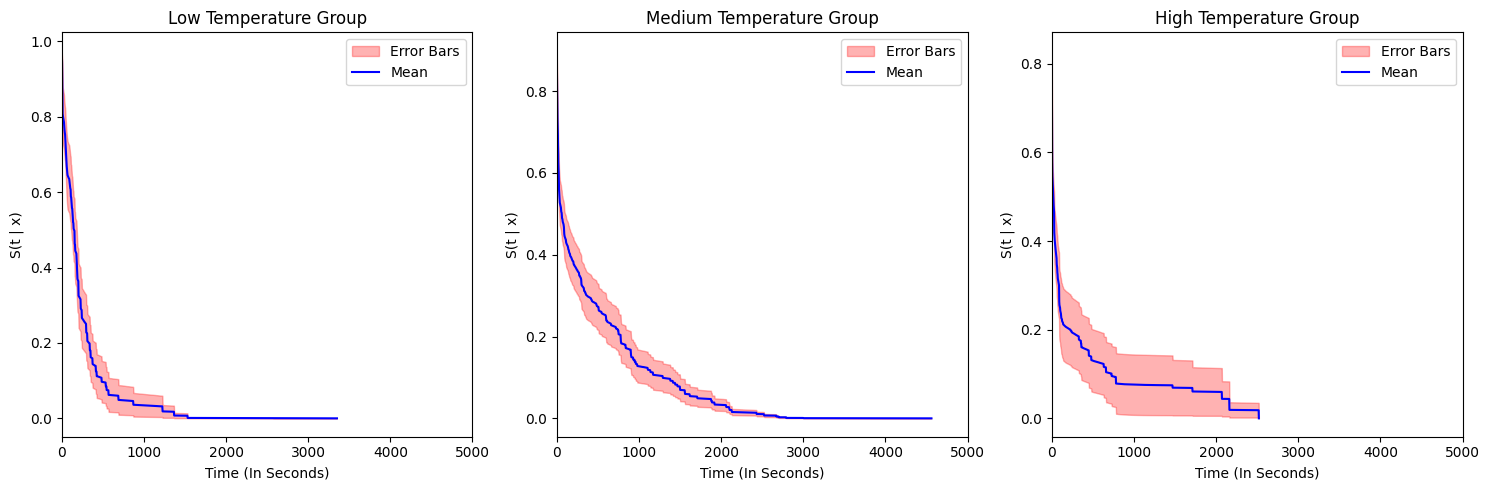

In [14]:
def graph_mean_and_sem(surv, group_name, ax):
    surv['mean'] = surv.mean(axis=1)
    surv['sem'] = surv.sem(axis='columns')

    # Calculate the upper and lower error bounds
    surv['upper_bound'] = surv['mean'] + surv['sem']
    surv['lower_bound'] = surv['mean'] - surv['sem']

    # Plot the error bars
    ax.fill_between(surv.index, surv['lower_bound'], surv['upper_bound'], color='red', alpha=0.3, label='Error Bars')

    # Plot the mean line
    ax.plot(surv.index, surv['mean'], color='blue', label='Mean')

    # Set the X-axis range from 0 to 5000
    ax.set_xlim(0, 5000)

    # Set the axis labels and title
    ax.set_xlabel('Time (In Seconds)')
    ax.set_ylabel('S(t | x)')
    ax.set_title(f'{group_name} Group')

    # Add a legend
    ax.legend()


# Create a 1x3 subplot grid for three groups
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

interval = 150
for idx, group in enumerate(temp_groups):
    print(group)
    df = temp_groups[group]
    cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']
    df_train = df[cols_input]
    fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(df_train, 1000)
    surv = base_model.predict_surv_df(x_test)
    
    # Update the data and label for each group within the loop
    graph_mean_and_sem(surv, f'{group} Temperature', axes[idx])

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plot with all three graphs
plt.show()


Low
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
estimated lambda 2.962962962962963
Medium
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
estimated lambda 6.407407407407407
High
INSIDE Callback Class, Jonah
INSIDE Callback Class, Jonah
estimated lambda 1.9259259259259258


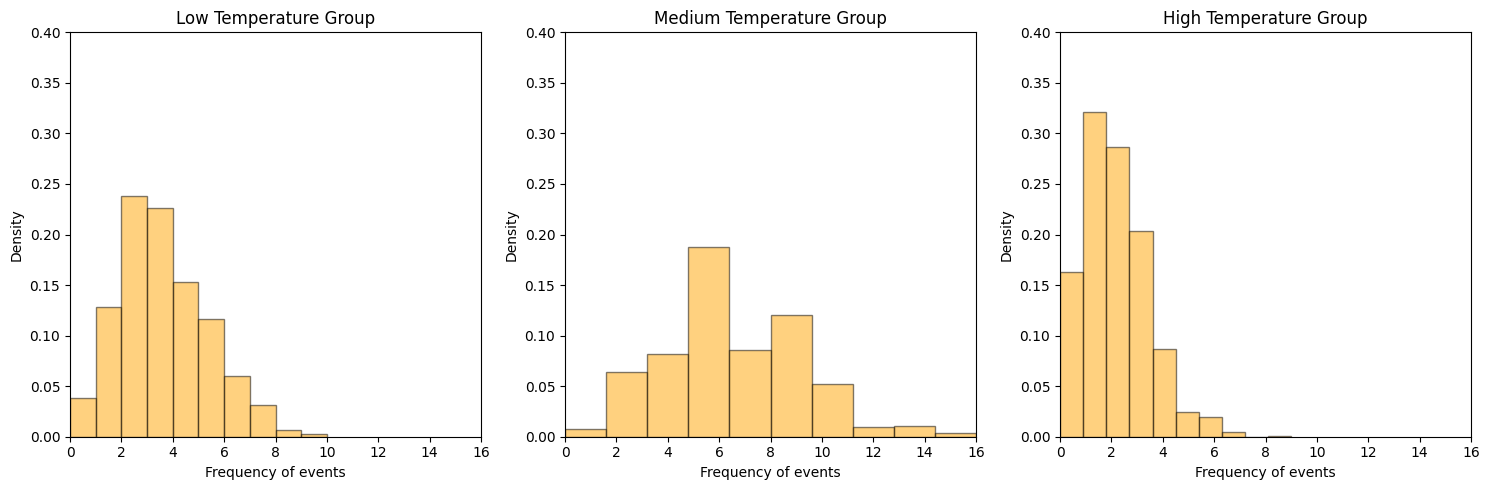

In [20]:
def graph_and_fit_poisson(grouped_arrivals, group_name, ax):
    # Extract x-axis values and counts from the data
    x_values = [item[0] for item in grouped_arrivals]
    counts = [item[1] for item in grouped_arrivals]

    # Find the mean of the data
    lambda_fit = np.mean(counts)
    print('estimated lambda', lambda_fit)

    # Generate 1000 values from the Poisson distribution
    generated_values = stats.poisson.rvs(mu=lambda_fit, size=1000)
    ax.hist(generated_values, bins=10, density=True, edgecolor='black', alpha=0.5,  color='orange', label='Generated Values')

    # Set the X-axis range from 0 to 5000
    ax.set_xlim(0, 16)
    ax.set_ylim(0, .4)

    ax.set_xlabel('Frequency of events')
    ax.set_ylabel('Density')
    ax.set_title(f'{group_name} Temperature Group')


# Create a 1x3 subplot grid for three groups
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

interval = 150
for idx, group in enumerate(temp_groups):
    print(group)
    df = temp_groups[group]
    cols_input = ['interval', 'status', 'temp', 'dwpt', 'wspd', 'coco', 'same_species']
    df_train = df[cols_input]
    fit_model, base_model, x_test, df_test, x_mapper = run_pycox_on_group(df_train, 1000)
    surv = base_model.predict_surv_df(x_test)
    
    grouped_arrivals, _, _ = group_by_length_of_interval(interval, df)
    
    # Pass the corresponding group name and axis object to the function
    graph_and_fit_poisson(grouped_arrivals, group, axes[idx])
    

# Adjust layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plot with all three graphs
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter

def run_bin_temp_analysis(df, binned_column, min_values_per_group=80):
    # Find the range of the `temp` column
    temp_min = df[binned_column].min()
    temp_max = df[binned_column].max()

    print(f"Photo data {binned_column} range")
    print(temp_min)
    print(temp_max)

    # Calculate the initial range of each group based on the total range of `temp`
    group_range = (temp_max - temp_min) / 3

    # Calculate the number of data points in each bin
    freq, _ = np.histogram(df[binned_column], bins=[temp_min, temp_min+group_range, temp_min+2*group_range, temp_max])

    print(f"freq", freq)

    # While the minimum frequency is less than the desired minimum values per group,
    # we adjust the bin edges and recalculate the frequencies
    while min(freq) < min_values_per_group and temp_max - temp_min > group_range:
        temp_max -= group_range
        print()
        freq, _ = np.histogram(df[binned_column], bins=[temp_min, temp_min+group_range, temp_min+(2*group_range), temp_max])

    print(f"Adjusted max temperature: {temp_max}", freq)

    # Create a new column in the DataFrame to hold the temperature group for each row
    df['binned_group'] = pd.cut(df[binned_column], bins=[temp_min, temp_min + group_range, temp_max], labels=['Low', 'Medium', 'High'])

    group_object = {}
    # Print out the DataFrame grouped by temperature group
    for name, group in df.groupby('binned_group'):
        print(f"Group: {name}\n")
        print(f"Number of rows in group: {len(group)}\n")
        group_object.update({name: group})
        group_temp_range = f"{name}: {group[binned_column].min()} - {group[binned_column].max()}"
        print('group_temp_range', group_temp_range)

        status = np.ones(len(group))

        cph = CoxPHFitter()
        cph.fit(group, duration_col='interval', event_col='status', formula="same_species + temp + wspd + dwpt + coco")

        cph.print_summary()

    return group_object

# df_minus_short_interval_same_species
temp_groups = run_bin_temp_analysis(interval_and_weather_merged, 'temp', min_values_per_group=80)


Photo data temp range
12.0
31.0
freq [ 86 156  50]


ValueError: `bins` must increase monotonically, when an array

In [ ]:

def group_temp_evenly(df, column_name, num_groups=3):
    # Sort the DataFrame by the 'temp' column in ascending order
    sorted_df = df.sort_values(by=column_name)

    # Use pd.qcut() to create three evenly sized groups based on the 'temp' column
    # Labels will be automatically generated as 'Group_1', 'Group_2', 'Group_3'
    sorted_df['temp_group'] = pd.qcut(sorted_df[column_name], q=num_groups, labels=False)

    return sorted_df

# Example usage:
# Assuming 'df' is your DataFrame and 'temp' is the column you want to group.
df_with_temp_groups = group_temp_evenly(interval_and_weather_merged, 'temp', num_groups=3)
df_with_temp_groups

group_lengths = df_with_temp_groups['temp_group'].value_counts().sort_index()
df_with_temp_groups['temp_group'].value_counts()

0    118
1    113
2     61
Name: temp_group, dtype: int64

In [ ]:
df_with_temp_groups[df_with_temp_groups['temp_group'] == 2]['temp'].max()

31.0